# IMPORTANT
1. the data folder must be provided correctly in lidar_utils python file line 4
2. the project is done based on the Nuscenes Full dataset (v1.0), the mini version which contains 10 scenes
download from (https://www.nuscenes.org/nuscenes#download)
2. this is a code to implement an occupancy grid using LIDAR data .
3. to get the results correctly you have to choose and compile one option of the options offered in this notebook
4. there are 2 options which represent the input data to be fed to the occupancy grid.
5. the OPTION 1 is to generate the input data for a WHOLE SCENE (PREFERED) FROM 0 to 9 (we have 10 scenes) .
6. the option 2  is to generate the input data for a SPECIFIC SAMPLE of a specific scene.
7. after choosing an option you can compile the main code.

# NOTES:
- there is possibilitiy to see the video of the scene in the code below.
you can also retrieve any camera image for any scene and any sample.
- the size of the grid is done automatically according to the data fed (by taking the maximum and minimum x,y point) the offset terms you see in the code is just the minimum to fit the grid in the graph, because this is a global grid so the minimum point could be like (500,900) !, so we just subtract all points from this minimum to bring it to (0,0).
- the occupancy grid needs further processing like filtering the moving object, filtering the ego body and the road surface, the latter can be done easily by determining a z threshold to eleminate the road surface and x,y threshold w.r.t ego lidar frame to eliminate the ego body detections

In [2]:
%matplotlib inline
from lidar_utils import *
import numpy as np

## Here is option 1, the input data for the grid is for a whole scene (preferred), will take some time in compiling

In [8]:
###################FOR WHOLE SCENE###################
##change the number of scene in the variable SCENE_NUMBER
SCENE_NUMBER=1
grid_resolution=0.5
lidar_object=lidar()
lidar_points,lidar_pose=lidar_object.get_all_points(SCENE_NUMBER)
lidar_points=np.array(lidar_points,dtype=float)
lidar_pose=np.array(lidar_pose,dtype=float)
x_size,y_size,x_offset,y_offset=lidar_object.get_grid_size_and_offset(lidar_points,lidar_pose,grid_resolution)
lidar_points=lidar_points-[x_offset,y_offset]
lidar_pose=lidar_pose-[x_offset,y_offset]

## Here is option 2, the input data for the grid is for just one sample

In [3]:
#change the number of scene and number of sample in the variable SCENE_NUMBER,SAMPLE_NUMBER 
SCENE_NUMBER=1
SAMPLE_NUMBER=0
grid_resolution=0.5
lidar_object=lidar()
lidar_points=lidar_object.get_lidar_sample(SCENE_NUMBER,SAMPLE_NUMBER)
lidar_points=np.array(lidar_points,dtype=float).T
lidar_pose=lidar_object.get_lidar_pose(SCENE_NUMBER,SAMPLE_NUMBER)
lidar_pose = np.full([len(lidar_points), 2], lidar_pose, dtype = float) # duplicate the pose to correspond points array length
x_size,y_size,x_offset,y_offset=lidar_object.get_grid_size_and_offset(lidar_points,lidar_pose,grid_resolution)
lidar_points=lidar_points-[x_offset,y_offset]
lidar_pose=lidar_pose-[x_offset,y_offset]

# This is the main code of the occupancy grid implementation , you have to compile it  after compiling one option

/home/nuscenes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/home/nuscenes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp


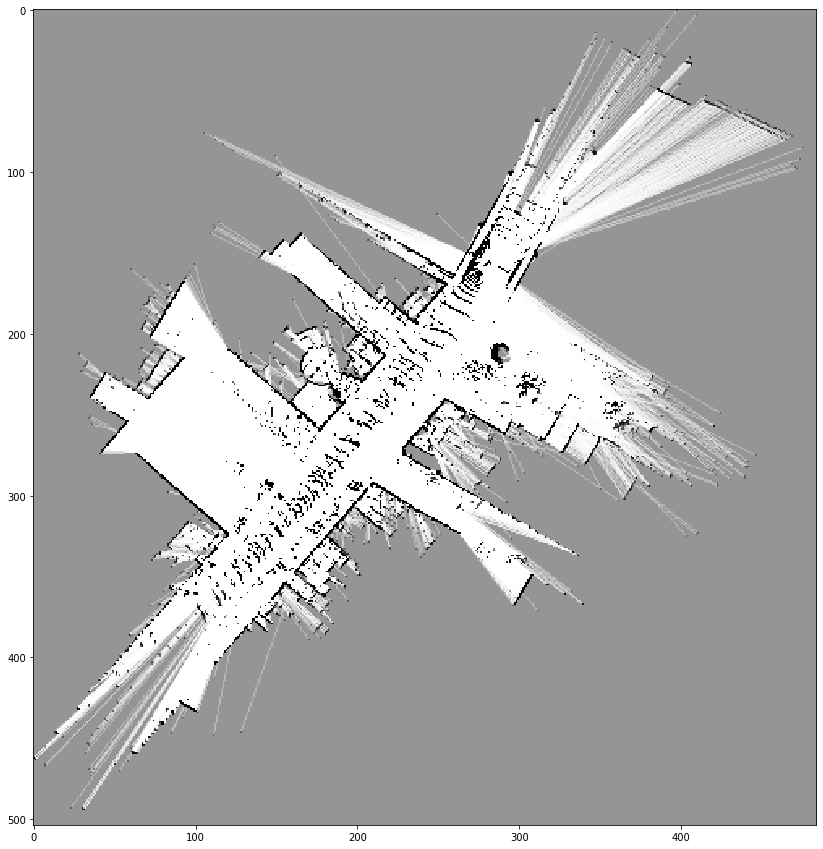

In [9]:
%matplotlib inline
from time import sleep
import numpy as np 
import matplotlib.pyplot as plt
from bresenham import bresenham

def discretize(points): 
    return np.floor(np.multiply(points,1/grid_resolution))  

prior = np.log(0.5 / (1 - 0.5)) # prior knowledge about the environment (usually fifty fifty)
logodds= np.ndarray(shape=(x_size,y_size)) 
logodds=np.zeros_like(logodds)
p = 1 - 1. / (1 + np.exp(logodds))  # convert to probability
lidar_points_discretized=discretize(lidar_points)           # MAP RADAR POINTS TO CELLS
lidar_pose_discretized=discretize(lidar_pose)          # MAP lidar POSES TO CELLS

#EXTRACT BRESENHAM LINE TO BE UPDATED AS FREE (the line between the lidar and the detection)
for i in range(len(lidar_points_discretized)):

    line=list(bresenham(int(lidar_pose_discretized[i,0]),int(lidar_pose_discretized[i,1]), \
                        int(lidar_points_discretized[i,0]),int(lidar_points_discretized[i,1])))
    line=np.array(line)
        
    np.delete(line,line[len(line)-1])      #DELETE THE LAST POINT IN THE LINE WHICH REPRESENT THE EGO ITSELF
    j=int(lidar_points_discretized[i][0])
    k=int(lidar_points_discretized[i][1])
    
    occupied_inv_sensor_model=np.log(0.7 / (1 - 0.7))   #ISM IS 0.7 FOR OCCUPIED (depends on your sesor)
    # UPDATE THE PROBABILITY IF occupied
    logodds[j][k] = logodds[j][k] - prior + occupied_inv_sensor_model
    
     # LOOP IN THE BRESENHAM LINE POINTS TO UPDATE ITS CELLS AS FREE
    for l in range(len(line)):  
        m=line[l][0]
        n=line[l][1]
        if logodds[m,n]<=0:
            free_inv_sensor_model=np.log(0.4 / (1 - 0.4))  #ISM IS 0.4 FOR free detections (depends on your sesor)
            # UPDATE THE PROBABILITY IF FREE
            logodds[m][n] = logodds[m][n] - prior + free_inv_sensor_model

#convert the logodd matrix to probability matrix to be able to plot it           
            
p = 1 - 1. / (1 + np.exp(logodds))
plt.figure(figsize=(15,15))
plt.imshow(p,cmap='Greys',vmin=0,vmax=1)



#plt.savefig('SCENE1LIDAR2.png')

## Here you can visualize the scene you are using in the occupancy grid implementation

In [10]:
#HERE YOU CAN SEE THE VIDEO OF THE ANY SCENE YOU WANT (change the scene_nbr)
scene_nbr=1
scenes = {0:'scene-0061',1:'scene-0103',2:'scene-0553',3:'scene-0655',4:'scene-0757',5:'scene-0796',\
          6:'scene-0916',7:'scene-1077',8:'scene-1094',9:'scene-1100'}

my_scene_token = nusc.field2token('scene', 'name', scenes[scene_nbr])[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

## render camera image of any sample in any scene

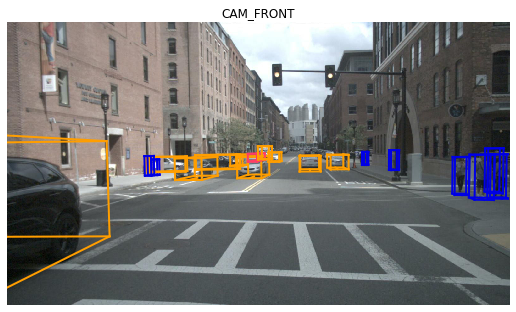

In [13]:
# GET ANY PICTURE from ANY SAMPLE JUST SCHANGE SCENE_NUMBER AND SAMPLE_NUMBER
SCENE_NUMBER=1
SAMPLE_NUMBER=5
sensor = 'CAM_FRONT'
sample_token=lidar_object.get_sample_token(SCENE_NUMBER,SAMPLE_NUMBER)
my_sample = nusc.get('sample', sample_token)
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
nusc.render_sample_data(cam_front_data['token'])
